In [1]:
import torch
import random
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaTokenizer, RobertaModel
from model_CodeBERT import Seq2Seq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy as cp
import renew_bleu
from collections import OrderedDict
from IPython.display import clear_output
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/envs/newpy37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
filenames = []
with open("selected_files.txt", "r") as f: # selected_files
    for l in f.readlines():
        filenames.append(l.strip())
num_of_files = len(filenames)
print("Number of C++ code files is: {}".format(num_of_files))

Number of C++ code files is: 9289


In [4]:
class CodeDataset (Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
        return
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        func = ""
        func_file = "func/{}.cpp".format(self.filenames[index])
        with open(func_file, "r") as f:
            for l in f.readlines():
                func += l
        func = " ".join(func.replace('\n', " ").split())

        label = ""
        label_file = "label/{}.text".format(self.filenames[index])
        with open(label_file, "r") as f:
            for l in f.readlines():
                label += l
        label = label.replace('//', " ").replace('/*', " ").replace('*/', " ").replace('\n', " ")
        label = " ".join(label.split())
        
        return func, label

In [5]:
size_t = int(num_of_files * 0.8)
size_val = int(num_of_files * 0.1)
train_data = CodeDataset(filenames[:5])
train_data = CodeDataset(filenames[:size_t])
val_data = CodeDataset(filenames[size_t:size_t+size_val])
test_data = CodeDataset(filenames[size_t+size_val:])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print("Training sample size: {}".format(size_t))
print(train_data[1])
print("")
print("validation sample size: {}".format(size_val))
print(val_data[1])
print("")
print("Test sample size: {}".format(num_of_files-size_t-size_val))
print(test_data[1])

Training sample size: 7431
('void print(int mat[][MAX], int n, int m) { for (int i = 0; i < n; i++) { for (int j = 0; j < m; j++) { cout << mat[i][j] << " "; } cout << endl; } }', 'Function to print the resultant matrix')

validation sample size: 928
('unsigned int doublefactorial(unsigned int n) { if (n == 0 || n==1) return 1; return n*doublefactorial(n-2); }', 'function to find double factorial of given number')

Test sample size: 930
('void push(Node** head_ref, int new_data) { Node* new_node = new Node(); new_node->data = new_data; new_node->next = (*head_ref); (*head_ref) = new_node; }', 'function to add a new node at the beginning of the list')


In [6]:
# build model (use defaul parameters)
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
config  = RobertaConfig.from_pretrained("microsoft/codebert-base")
encoder = RobertaModel.from_pretrained("microsoft/codebert-base")
decoder_layer = torch.nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=6)

In [7]:
token_length = []
for func, label in train_loader:
    for codes in func:
        token_length.append(len(tokenizer(codes)["input_ids"]))

mean_length = np.mean(token_length)
min_length = min(token_length)
max_length = max(token_length)

Mean of token length: 60.97160543668416
Min of token length: 7
Max of token length: 149


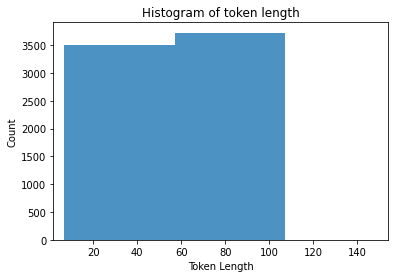

In [8]:
print("Mean of token length: {}".format(mean_length))
print("Min of token length: {}".format(min_length))
print("Max of token length: {}".format(max_length))
bins = np.arange(min_length, max_length, 50) 
plt.xlim([min_length-5, max_length+5])
plt.hist(token_length, bins=bins, alpha=0.8)
plt.title('Histogram of token length')
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.show()

In [9]:
# initialize a seq2seq model
model = Seq2Seq(
    encoder=encoder, 
    decoder=decoder, 
    config=config,
    beam_size=10, # beam size for beam search, default = 10
    max_length=128, # output tokens length
    sos_id=tokenizer.cls_token_id, # start of symbol ids in target for beam search
    eos_id=tokenizer.sep_token_id  # end of symbol ids in target for beam search. 
)

# load pretrained model
pytorch_model = "./PretrainedModel/java/pytorch_model.bin"
checkpoint = torch.load(pytorch_model, map_location='cpu')
model.load_state_dict(checkpoint)
model.to(device)

Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [10]:
def convert_to_tokens(codes, tokenizer, truncation, max_length):
    tokens = tokenizer(codes, truncation=truncation, padding="max_length", max_length=max_length)
    codes_ids = torch.tensor(tokens["input_ids"])
    codes_mask = torch.tensor(tokens["attention_mask"])
    return codes_ids.to(device), codes_mask.to(device)

In [11]:
def tokens_to_labels(tokens, tokenizer):
    labels = []
    for token in tokens:
        t_seq = list(token[0].cpu().numpy())
        if 0 in t_seq: 
            t_seq = t_seq[:t_seq.index(0)]
        label = tokenizer.decode(t_seq, clean_up_tokenization_spaces=False)
        labels.append(label)
    return labels

In [12]:
MAX_LENGTH = 110

In [13]:
# using pre-trained model to make a test
model.eval()
codes_act = []
labels_act = []
labels_pred = []
for i, (codes, labels) in enumerate(test_loader):
    codes_act.extend(codes)
    labels_act.extend(labels)
    codes_ids, codes_mask = convert_to_tokens(codes, tokenizer, True, MAX_LENGTH)
    tokens = model(source_ids=codes_ids, source_mask=codes_mask)
    labels_output = tokens_to_labels(tokens, tokenizer)
    labels_pred.extend(labels_output)
    if i%10==0:
        print(i)

0
10


In [14]:
def bleu4_score(labels_pred, labels_act):
    (map_act, map_pred) = renew_bleu.mapping(labels_act, labels_pred)
    bleu4 = renew_bleu.bleuFromMaps(map_act, map_pred)[0]
    return round(bleu4, 4)

In [15]:
bleu4_score = bleu4_score(labels_pred, labels_act)
print("The BLEU-4 score using the pre-trained model: {:.4f}.".format(bleu4_score))
print("")
print("Examples using pre-trained model")
for i, (code, label, prediction) in enumerate(zip(codes_act[10:20], labels_act[10:20], labels_pred[10:20])):
    print(i+1)
    print(code)
    print("")
    print(label)
    print("")
    print(prediction)
    print("")

The BLEU-4 score using the pre-trained model: 0.1421.

Examples using pre-trained model
1
unsigned int aModM(string s, unsigned int mod) { unsigned int number = 0; for (unsigned int i = 0; i < s.length(); i++) { number = (number*10 + (s[i] - '0')); number %= mod; } return number; }

utility function to calculate a%m

Calculate the number of digits .

2
int nextChar(int freq[], int dist[]) { int max = INT_MIN; for (int i = 0; i < MAX_CHAR; i++) if (dist[i] <= 0 && freq[i] > 0 && (max == INT_MIN || freq[i] > freq[max])) max = i; return max; }

The function returns next eligible character with maximum frequency (Greedy!!) and zero or negative distance

Returns the next character .

3
void find_min(struct node* mini) { cout << "min of heap is: " << mini->key << endl; }

Function to find min node in the heap

Finds the minimum of the given node .

4
void printEulerTour(int root, int N) { int index = 0; eulerTree(root, index); for (int i = 0; i < (2*N-1); i++) cout << Euler[i] << " "; }

Fun

## Re-train model using C++ training dataset

In [13]:
def train_model(model, data_loader):
    model.train()
    train_loss = []
    for i, (codes, labels) in enumerate(data_loader):
        # print(i)
        codes_ids, codes_mask = convert_to_tokens(codes, tokenizer, True, MAX_LENGTH)
        labels_ids, labels_mask = convert_to_tokens(labels, tokenizer, True, MAX_LENGTH)  
        optimizer.zero_grad()
        loss, _, _ = model(
            source_ids = codes_ids,
            source_mask = codes_mask,
            target_ids = labels_ids,
            target_mask = labels_mask)       
        loss.backward()
        optimizer.step()
        train_loss.append(float(loss.detach().cpu().mean().numpy()))

    train_epoch_loss = np.mean(train_loss) 
    return train_epoch_loss

In [14]:
def valid_model(model, data_loader):
    model.eval()
    val_loss = []
    for i, (codes, labels) in enumerate(data_loader):
        # print(i)
        codes_ids, codes_mask = convert_to_tokens(codes, tokenizer, True, MAX_LENGTH)
        labels_ids, labels_mask = convert_to_tokens(labels, tokenizer, True, MAX_LENGTH)               
        loss, _, _ = model(
            source_ids = codes_ids,
            source_mask = codes_mask,
            target_ids = labels_ids,
            target_mask = labels_mask)
        val_loss.append(float(loss.detach().cpu().mean().numpy()))

    val_epoch_loss = np.mean(val_loss)
    return val_epoch_loss

In [15]:
def best_model(model, best_para, loss):
    if best_para["Loss"] > loss:
        best_para["Loss"] = loss
        model_state_dict = {key:value.to('cpu') for key, value in model.state_dict().items()}
        model_state_dict = OrderedDict(model_state_dict)
        best_para["Model"] = model_state_dict

In [16]:
EPOCHES = 30
LEARNING_RATE = 1e-5
model_para = {"Model": None, "Epoch": 0}
best_model_para = {"Model": None, "Loss": np.inf}
train_loss = []
val_loss = []

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHES):
    epoch_train_loss = train_model(model, train_loader)
    train_loss.append(epoch_train_loss)
    print("Epoch [{}], training loss: {:.6f}.".format(epoch, epoch_train_loss))
    epoch_val_loss = valid_model(model, val_loader)
    val_loss.append(epoch_val_loss)
    print("Epoch [{}], validation loss: {:.6f}.".format(epoch, epoch_val_loss))
    
    epoch_state_dict = {key:value.to('cpu') for key, value in model.state_dict().items()}
    epoch_state_dict = OrderedDict(epoch_state_dict)
    para_file = "./Epoch_CodeBERT_Para/" + str(epoch) + "_codeBERT_para.bin"
    torch.save(epoch_state_dict, para_file)
    
    if best_model_para["Loss"] > epoch_val_loss:
        best_model_para["Loss"] = epoch_val_loss
        state_dict = {key:value.to('cpu') for key, value in model.state_dict().items()}
        state_dict = OrderedDict(state_dict)
        best_model_para["Model"] = state_dict
# save the best model        
torch.save(best_model_para["Model"], "./codeBERT_model_best.bin")

Epoch [0], training loss: 3.353276.
Epoch [0], validation loss: 2.971897.
Epoch [1], training loss: 2.851434.
Epoch [1], validation loss: 2.766125.
Epoch [2], training loss: 2.618222.
Epoch [2], validation loss: 2.651505.
Epoch [3], training loss: 2.453126.
Epoch [3], validation loss: 2.569354.
Epoch [4], training loss: 2.319755.
Epoch [4], validation loss: 2.499620.
Epoch [5], training loss: 2.220275.
Epoch [5], validation loss: 2.450132.
Epoch [6], training loss: 2.112122.
Epoch [6], validation loss: 2.415442.
Epoch [7], training loss: 2.018943.
Epoch [7], validation loss: 2.384732.
Epoch [8], training loss: 1.948543.
Epoch [8], validation loss: 2.359438.
Epoch [9], training loss: 1.866240.
Epoch [9], validation loss: 2.328853.
Epoch [10], training loss: 1.793417.
Epoch [10], validation loss: 2.311886.
Epoch [11], training loss: 1.743383.
Epoch [11], validation loss: 2.295072.
Epoch [12], training loss: 1.675505.
Epoch [12], validation loss: 2.278812.
Epoch [13], training loss: 1.607

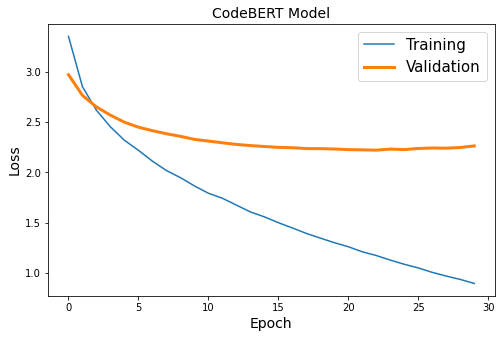

In [17]:
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_loss[:])), train_loss[:], label='Training')
plt.plot(np.arange(len(val_loss[:])), val_loss[:], label='Validation', linewidth=3)
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title("CodeBERT Model", fontsize=14)
plt.legend(fontsize=15)
plt.savefig('./codeBERT_model_loss.png')
plt.show() 

In [18]:
# the path for model parameter
arr = os.listdir('/home/jovyan/DeepLearningProject/Epoch_CodeBERT_Para')
arr.sort()
epoch_list = []
val_bleu4_score = []

for i in range(1, 31):
    epoch_list.append(str(arr[i]))
    print(arr[i])
    pytorch_model = "./Epoch_CodeBERT_Para/" + arr[i]
    checkpoint = torch.load(pytorch_model) # map_location='cpu'
    model.load_state_dict(checkpoint)
    model.to(device)

    model.eval()
    re_codes_act = []
    re_labels_act = []
    re_labels_pred = []
    
    for _, (codes, labels) in enumerate(val_loader):
        re_codes_act.extend(codes)
        re_labels_act.extend(labels)
        codes_ids, codes_mask = convert_to_tokens(codes, tokenizer, True, MAX_LENGTH)
        tokens = model(source_ids=codes_ids, source_mask=codes_mask)
        labels_output = tokens_to_labels(tokens, tokenizer)
        re_labels_pred.extend(labels_output)
    
    def bleu4_score(labels_pred, labels_act):
        (map_act, map_pred) = renew_bleu.mapping(labels_act, labels_pred)
        bleu4 = renew_bleu.bleuFromMaps(map_act, map_pred)[0]
        return round(bleu4, 4)

    re_bleu4_score = bleu4_score(re_labels_pred, re_labels_act)
    val_bleu4_score.append(re_bleu4_score)
    print(re_bleu4_score)

0_codeBERT_para.bin
0.2414
10_codeBERT_para.bin
0.2731
11_codeBERT_para.bin
0.2816
12_codeBERT_para.bin
0.2799
13_codeBERT_para.bin
0.2863
14_codeBERT_para.bin
0.289
15_codeBERT_para.bin
0.2881
16_codeBERT_para.bin
0.2934
17_codeBERT_para.bin
0.292
18_codeBERT_para.bin
0.2953
19_codeBERT_para.bin
0.2929
1_codeBERT_para.bin
0.2525
20_codeBERT_para.bin
0.2951
21_codeBERT_para.bin
0.3043
22_codeBERT_para.bin
0.299
23_codeBERT_para.bin
0.3035
24_codeBERT_para.bin
0.3028
25_codeBERT_para.bin
0.3053
26_codeBERT_para.bin
0.3058
27_codeBERT_para.bin
0.3046
28_codeBERT_para.bin
0.308
29_codeBERT_para.bin
0.3071
2_codeBERT_para.bin
0.2531
3_codeBERT_para.bin
0.2586
4_codeBERT_para.bin
0.2665
5_codeBERT_para.bin
0.2683
6_codeBERT_para.bin
0.2766
7_codeBERT_para.bin
0.2785
8_codeBERT_para.bin
0.2806
9_codeBERT_para.bin
0.2807


In [19]:
new_epoch_list = epoch_list.copy()
new_bleu4_score = val_bleu4_score.copy()
num_epoch = [int(i.split('_', 1)[0]) for i in new_epoch_list]
df_val_scores = pd.DataFrame(zip(new_epoch_list, new_bleu4_score, num_epoch), columns=['epoch','bleu_score','num_epoch'])
df_val_scores.sort_values('num_epoch', ascending = True, inplace=True)
df_val_scores.head()

,epoch,bleu_score,num_epoch
0,0_codeBERT_para.bin,0.2414,0
11,1_codeBERT_para.bin,0.2525,1
22,2_codeBERT_para.bin,0.2531,2
23,3_codeBERT_para.bin,0.2586,3
24,4_codeBERT_para.bin,0.2665,4


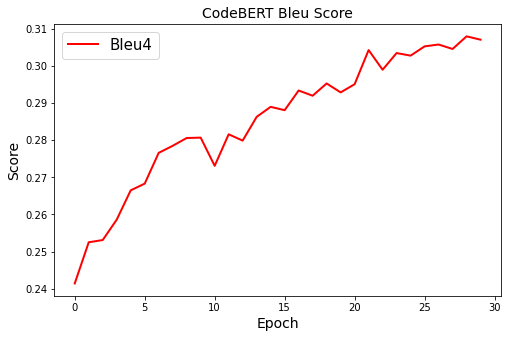

In [20]:
figure = plt.figure(figsize = [8, 5])
plt.plot(df_val_scores['num_epoch'], df_val_scores['bleu_score'], label='Bleu4', linewidth=2, color = 'red')
plt.ylabel('Score',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title("CodeBERT Bleu Score", fontsize=14)
plt.legend(fontsize=15)
plt.savefig('./CodeBERT_bleu4_score.png')
plt.show() 

## Model Evaluation

In [56]:
# Loading the best model 
model.load_state_dict(best_model_para["Model"])
model.to(device)

Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [57]:
# using pre-trained model to make a test
model.eval()
re_codes_act = []
re_labels_act = []
re_labels_pred = []
for i, (codes, labels) in enumerate(test_loader):
    re_codes_act.extend(codes)
    re_labels_act.extend(labels)
    codes_ids, codes_mask = convert_to_tokens(codes, tokenizer, True, MAX_LENGTH)
    tokens = model(source_ids=codes_ids, source_mask=codes_mask)
    labels_output = tokens_to_labels(tokens, tokenizer)
    re_labels_pred.extend(labels_output)
    if i%10==0:
        print(i)
    # if i == 5:
    #     break

0
10


In [58]:
def bleu4_score(labels_pred, labels_act):
    (map_act, map_pred) = renew_bleu.mapping(labels_act, labels_pred)
    bleu4 = renew_bleu.bleuFromMaps(map_act, map_pred)[0]
    return round(bleu4, 4)

In [59]:
re_bleu4_score = bleu4_score(re_labels_pred, re_labels_act)
print("The BLEU-4 score using the retrained model: {:.4f}.".format(re_bleu4_score))
print("")
print("Examples after retraining model")
for i, (code, label, prediction) in enumerate(zip(re_codes_act[10:20], re_labels_act[10:20], re_labels_pred[10:20])):
    print(i+1)
    print(code)
    print("")
    print(label)
    print("")
    print(prediction)
    print("")

The BLEU-4 score using the retrained model: 0.3172.

Examples after retraining model
1
unsigned int aModM(string s, unsigned int mod) { unsigned int number = 0; for (unsigned int i = 0; i < s.length(); i++) { number = (number*10 + (s[i] - '0')); number %= mod; } return number; }

utility function to calculate a%m

function to calculate a mod m

2
int nextChar(int freq[], int dist[]) { int max = INT_MIN; for (int i = 0; i < MAX_CHAR; i++) if (dist[i] <= 0 && freq[i] > 0 && (max == INT_MIN || freq[i] > freq[max])) max = i; return max; }

The function returns next eligible character with maximum frequency (Greedy!!) and zero or negative distance

Function to return the next character

3
void find_min(struct node* mini) { cout << "min of heap is: " << mini->key << endl; }

Function to find min node in the heap

Function to find the min of node

4
void printEulerTour(int root, int N) { int index = 0; eulerTree(root, index); for (int i = 0; i < (2*N-1); i++) cout << Euler[i] << " "; }

Funct